In [1]:
import requests
def download_lichess_pgn(username, token, output_file):
    """
    Télécharge toutes les parties d'un utilisateur au format PGN et les sauvegarde dans un fichier.

    Args:
        username (str): Nom d'utilisateur Lichess.
        token (str): Jeton d'accès Lichess.
        output_file (str): Chemin où sauvegarder le fichier PGN.

    """
    url = f'https://lichess.org/api/games/user/{username}'
    headers = {
        'Authorization': f'Bearer {token}',
        'Accept': 'application/x-chess-pgn'
    }
    params = {
        'max': 3000,
        'clocks': 1,
        'evals': 1,
        'Opening':1,
        'pgnInJson': False,
    }
    response = requests.get(url, headers=headers, params=params, stream=True)

    if response.status_code != 200:
        raise Exception(f"Erreur lors du téléchargement : {response.status_code}")


    with open(output_file, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Fichier PGN téléchargé et sauvegardé sous {output_file}")


username = 'EricRosen'
token = 'lip_IolWV17XjlvaNCEvqeXd'
output_file = 'games.pgn'
download_lichess_pgn(username, token, output_file)

Fichier PGN téléchargé et sauvegardé sous games.pgn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install chess
import chess.pgn
!pip install zstandard
import zstandard as zstd
import statistics as sta
import datetime
import time


compressed_file = "/content/lichess_db_standard_rated_2014-09.pgn.zst"   # Chemin des fichiers
decompressed_file = "/content/lichess_db_standard_rated_2014-09.pgn"


with open(compressed_file, 'rb') as compressed:   # Décompression du zst
    with open(decompressed_file, 'wb') as decompressed:
        dctx = zstd.ZstdDecompressor()
        dctx.copy_stream(compressed, decompressed)

pgn_file_path=decompressed_file

In [26]:

class ChessGame:

    def __init__(self, game, username):
        self.white_player = game.headers.get("White", "Unknown")
        self.black_player = game.headers.get("Black", "Unknown")
         # Gestion des valeurs Elo invalides
        try:
            self.white_elo = int(game.headers.get("WhiteElo", 0)) if game.headers.get("WhiteElo") and game.headers.get("WhiteElo").isdigit() else None
        except ValueError:
            self.white_elo = None

        try:
            self.black_elo = int(game.headers.get("BlackElo", 0)) if game.headers.get("BlackElo") and game.headers.get("BlackElo").isdigit() else None
        except ValueError:
            self.black_elo = None
        self.result = game.headers.get("Result", "Unknown")
        self.termination = game.headers.get("Termination", "Unknown")
        self.opening = game.headers.get("Opening", "Unknown")
        self.time_control = game.headers.get("TimeControl", "Unknown")
        self.moves, self.evaluations, self.clocks = self._extract_moves(game)
        self.move_count = len(self.moves)

        self.game_type = self._classify_game_type(self.time_control)  # bullet (le plus rapide), blitz, rapid ou classique (le plus lent)
        self.username = username
        self.centipawn_losses = self._calculate_centipawn_losses()

        Events=important_events(self.moves)
        self.white_queen_taken_bool=main_events(Events,'W','Q')[0]
        self.white_queen_taken_move=main_events(Events,'W','Q')[1]
        self.black_queen_taken_bool=main_events(Events,'B','Q')[0]
        self.black_queen_taken_move=main_events(Events,'B','Q')[1]
        self.white_castling_bool=main_events(Events,'W','C')[0]
        self.white_castling_move=main_events(Events,'W','C')[1]
        self.black_castling_bool=main_events(Events,'B','C')[0]
        self.black_castling_move=main_events(Events,'B','C')[1]
        if self.white_queen_taken_bool and self.black_queen_taken_bool :
            self.queen_exchange_bool= abs(self.black_queen_taken_move-self.white_queen_taken_move)<2
        else : self.queen_exchange_bool= False
        if self.queen_exchange_bool :
            self.queen_exchange_move=max(self.white_queen_taken_move,self.black_queen_taken_move)
        else : self.queen_exchange_move='NaN'

    def _extract_moves(self, game):
        moves = []
        evaluations = []  #tab des evaluations
        clocks = []  #tab du temps restant
        for node in game.mainline():
            move = node.move.uci()
            moves.append(move)
            if "eval" in node.comment:
                    eval_str = node.comment.split("[%eval ")[1].split("]")[0]
                    try:
                        # Si l'évaluation est un chiffre, tronquer à [-12, 12]
                        eval_value = float(eval_str)
                        eval_value = max(-12, min(12, eval_value))  # Tronquer à [-12, 12]
                        evaluations.append(eval_value)
                    except ValueError:

                        if eval_str.startswith("#"):  #on tronque l evaluation a 12 en cas de mat en un certain nombres de coups
                            if eval_str[1:].isdigit():
                                evaluations.append(12)
                            elif eval_str[1:].startswith("-") and eval_str[2:].isdigit():
                                evaluations.append(-12)
                        else:
                            evaluations.append(None)
            else:
                evaluations.append(None)

            # Récupérer le temps restant
            if "clk" in node.comment:
                clk_str = node.comment.split("[%clk ")[1].split("]")[0]
                clocks.append(clk_str)
            else:
                clocks.append(None)

        return moves, evaluations, clocks

    def _calculate_centipawn_losses(self):
        """Calcule la perte en centipions pour chaque coup."""
        centipawn_losses = []
        for i in range(1, len(self.evaluations)):
            if self.evaluations[i] is not None and self.evaluations[i - 1] is not None:
                loss = abs(self.evaluations[i] - self.evaluations[i - 1])
                centipawn_losses.append(loss)
            else:
                centipawn_losses.append(None)  # Si une évaluation manque
        return centipawn_losses

    def _classify_game_type(self, time_control):
        """
        Classe le type de la partie en fonction du TimeControl.
        Exemples de time_control :
        - "300+5" : 5 minutes avec incrément 5 sec (blitz)
        - "60+0" : 1 minute sans incrément (bullet)
        - "1800+0" : 30 minutes sans incrément (rapid)
        """
        if not time_control or time_control == "-":
            return "Unknown"

        try:
            base, increment = time_control.split("+")
            base = int(base)  # Temps de base en secondes
            increment = int(increment)  # Incrément

            total_time = base + (40 * increment)
            if total_time < 180:  # 180 secondes=3 minutes
                return "Bullet"
            elif total_time <= 600:
              return "Blitz"
            elif total_time <= 1800:
              return "Rapid"
            else:
              return "Classical"   #plus de 30 minutes
        except ValueError:
            return "Unknown"

def fetch_games_from_pgn(pgn_file_path, username, max_games=100000):

    games_list = []


    with open(pgn_file_path) as pgn_file:
        for _ in range(max_games):
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break


            chess_game = ChessGame(game, username=username)


            games_list.append({           # d'autres variables peuvent s'ajouter
                "White": chess_game.white_player,
                "Black": chess_game.black_player,
                "WhiteElo": chess_game.white_elo,
                "BlackElo": chess_game.black_elo,
                "Result": chess_game.result,
                "Termination": chess_game.termination,
                "Opening": chess_game.opening,
                "TimeControl": chess_game.time_control,
                "MoveCount": chess_game.move_count,
                "Moves": chess_game.moves,
                "evaluations": chess_game.evaluations,
                "clocks":chess_game.clocks,
                "game_type":chess_game.game_type,
                "centipawn_losses": chess_game.centipawn_losses,
                "white_queen_taken_bool":chess_game.white_queen_taken_bool,
                "white_queen_taken_move":chess_game.white_queen_taken_move,
                "black_queen_taken_bool":chess_game.black_queen_taken_bool,
                "black_queen_taken_move":chess_game.black_queen_taken_move,
                "white_castling_bool":chess_game.white_castling_bool,
                "white_castling_move":chess_game.white_castling_move,
                "black_castling_bool":chess_game.black_castling_bool,
                "black_castling_move":chess_game.black_castling_move,
                "queen_exchange_bool":chess_game.queen_exchange_bool,
                "queen_exchange_move":chess_game.queen_exchange_move
            })

    return pd.DataFrame(games_list)



def statistiques_descriptives(df):


  results_count = df["Result"].value_counts()
  print("\nRépartition des résultats :")
  print(results_count)


  plt.figure(figsize=(6, 6))
  plt.pie(results_count, labels=results_count.index, autopct='%1.1f%%', colors=["lightgreen", "lightcoral", "lightblue"])
  plt.title("Répartition des résultats (Blancs, Noirs, Nulles)")
  plt.show()

  average_moves = df["MoveCount"].mean()
  print(f"\nNombre moyen de coups par partie : {average_moves:.2f}")


  plt.figure(figsize=(8, 5))
  plt.hist(df["MoveCount"], bins=20, color="skyblue", edgecolor="black")
  plt.title("Distribution du nombre de coups par partie")
  plt.xlabel("Nombre de coups")
  plt.ylabel("Fréquence")
  plt.show()



  df = df.rename(columns={"opening": "Opening", "result": "Result", "winner": "Winner"})
  df["Result"] = df["Result"].replace({"1-0": "White", "0-1": "Black", "1/2-1/2": "Draw"})

  # Obtenir les 20 ouvertures les plus fréquentes
  top_openings = df["Opening"].value_counts().head(20).index

  # Calculer le taux de victoire (win rate) pour les ouvertures
  opening_win_rate = (
    df[df["Result"] != "Draw"]
    .groupby("Opening")["Result"]
    .value_counts(normalize=True)
    .unstack()
    .loc[top_openings]
  )


  opening_win_rate["White Win Rate (%)"] = (opening_win_rate["White"] * 100).round(2)


  result_df = opening_win_rate[["White Win Rate (%)"]].reset_index()


  print(result_df)
  game_type_counts = df["game_type"].value_counts()
  print("\nNombre de parties par type :")
  print(game_type_counts)

  # Visualisation sous forme de diagramme
  plt.figure(figsize=(8, 6))
  game_type_counts.plot(kind="bar", color=["lightblue", "lightgreen", "lightcoral", "gold"])
  plt.title("Nombre de parties par type")
  plt.xlabel("Type de partie")
  plt.ylabel("Nombre de parties")
  plt.xticks(rotation=0)
  plt.show()

  centipawn_losses = []
  max_moves = 0

  for _, row in df.iterrows():
        evaluations = row["evaluations"]
        if evaluations and isinstance(evaluations, list):
            losses = []
            for i in range(1, len(evaluations)):
                if evaluations[i] is not None and evaluations[i - 1] is not None:
                    loss = abs(evaluations[i] - evaluations[i - 1])
                    losses.append(loss)
                else:
                    losses.append(None)  # Si une évaluation manque, ignorer ce coup
            centipawn_losses.append(losses)
            max_moves = max(max_moves, len(losses))

    # Calculer la perte moyenne par numéro de coup
  losses_per_move = [[] for _ in range(max_moves)]
  for losses in centipawn_losses:
      for move_idx, loss in enumerate(losses):
          if loss is not None:
              losses_per_move[move_idx].append(loss)


  average_losses = [np.mean(move_losses) if len(move_losses) > 0 else None for move_losses in losses_per_move]

  plt.figure(figsize=(12, 6))
  plt.plot(range(1, len(average_losses) + 1), average_losses, marker="o", color="blue")
  plt.title("Perte moyenne de centipions par numéro de coup")
  plt.xlabel("Numéro de coup")
  plt.ylabel("Perte moyenne de centipions")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

def plays_white(data): #this function takes the dataframe of the games of one player and gives back a column composed of 0s and 1s : 1 if the game was won
    White=[]
    for i in data['White']:
        if i==username:
            White.append(1)
        else:
            White.append(0)
    return White

def won (data) : #this function takes the dataframe of the games of one player and gives back a column composed of 0s and 1s : 1 if the player played white
    Won=[]
    for i in range(len(data['Result'])):
        if data['Plays_white'][i]==1:
            Won.append(int([*data['Result'][i]][0]))
        else:
            Won.append(int([*data['Result'][i]][2]))
    return Won

def convert_clock(list_clock): #this function converts a chess clock in format '00:00:59" into an integer that is the number of seconds
    new_clock=[]
    for i in list_clock :
        x = time.strptime(i.split(',')[0],'%H:%M:%S')
        new_clock.append(datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds())
    return new_clock


def add_variables_perso (data): #this function takes the dataframe of the games of one player and adds a few columns to the data set, namely the mean evaluations and seconds used at relevant moments of the game
    # Retrieve only the chosen player evaluations and clocks
    their_times=[]
    their_evals=[]
    for i in range(len(data['White'])):
        if data['White'][i]==1 :
            their_times.append(convert_clock(data['clocks'][i][::2]))
            their_evals.append(data['evaluations'][i][::2])
        else :
            their_times.append(convert_clock(data['clocks'][i][1::2]))
            their_evals.append(data['evaluations'][i][1::2])
    #initiate new variables
    m_o_r=[]
    m_m_1_r=[]
    m_m_2_r=[]
    m_e_r=[]
    m_o_t=[]
    m_m_1_t=[]
    m_m_2_t=[]
    m_e_t=[]
    Len_game=[]
    for i in range(len(data['White'])): #compute the variables
        try :
            First_eval=their_evals[i][0]
        except IndexError :
            their_evals[i]=[None]
        if (First_eval is None) :
            means_ev=['NaN' for k in range(4)]
            n= len(their_times[i])
            if n>26 :
                indices=[(0,6), (6,16), (16,26),(26,n)] #split the moves in four categories : opening (5 moves), middle game 1 (10 moves), middle game 2 (10 moves), end game (The remaining moves)
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices] #compute for each slice the mean time taken for the move
                Len_game.append("Long") #Get the length of the game based on the number of moves
            elif n>16 :
                indices=[(0,6), (6,16),(16,n)]
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices]
                means_time.append('NaN') #NaN is added if there wasn't enough moves in the game to complete the last slices
                Len_game.append("Medium")
            elif n>6 :
                indices=[(0,6), (6,n)]
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices]
                means_time+=['NaN','NaN']
                Len_game.append("Short")
            else : #If the game had less than 6 moves the analysis in terms of opening, middle game, is not useful : nothing is computed
                means_time=['NaN' for k in range(4)]
                Len_game.append("Too Short")
        else :
            their_evals_clean_i=[]
            for j in their_evals[i] :
                if j is None :
                    their_evals_clean_i.append(0)
                else :
                    their_evals_clean_i.append(j)
            n= len(their_evals_clean_i)
            if n>26 :
                indices=[(0,6), (6,16), (16,26),(26,n)] #split the moves in four categories : opening (5 moves), middle game 1 (10 moves), middle game 2 (10 moves), end game (The remaining moves)
                means_ev=[sta.mean(their_evals_clean_i[a:b]) for a,b in indices] #compute for each slice the mean rating of the move
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices] #compute for each slice the mean time taken for the move
                Len_game.append("Long") #Get the length of the game based on the number of moves
            elif n>16 :
                indices=[(0,6), (6,16),(16,n)]
                means_ev=[sta.mean(their_evals_clean_i[a:b]) for a,b in indices]
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices]
                means_time.append('NaN') #NaN is added if there wasn't enough moves in the game to complete the last slices
                means_ev.append('NaN')
                Len_game.append("Medium")
            elif n>6 :
                indices=[(0,6), (6,n)]
                means_ev=[sta.mean(their_evals_clean_i[a:b]) for a,b in indices]
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices]
                means_time+=['NaN','NaN']
                means_ev+=['NaN','NaN']
                Len_game.append("Short")
            else : #If the game had less than 6 moves the analysis in terms of opening, middle game, is not useful : nothing is computed
                means_ev=['NaN' for k in range(4)]
                means_time=['NaN' for k in range(4)]
                Len_game.append("Too Short")

        m_o_r.append(means_ev[0]) #Then the computed measures are added
        m_m_1_r.append(means_ev[1])
        m_m_2_r.append(means_ev[2])
        m_e_r.append(means_ev[3])
        m_o_t.append(means_time[0])
        m_m_1_t.append(means_time[1])
        m_m_2_t.append(means_time[2])
        m_e_t.append(means_time[3])
    data["length_game"]=Len_game
    data["mean_opening_rating"]=m_o_r #the new colums are added to the data set
    data["mean_middle1_rating"]=m_m_1_r
    data["mean_middle2_rating"]=m_m_2_r
    data["mean_end_rating"]=m_e_r
    data["mean_opening_time"]=m_o_t
    data["mean_middle1_time"]=m_m_1_t
    data["mean_middle2_time"]=m_m_2_t
    data["mean_end_time"]=m_e_t

def convert(a,b) : #this function takes a position on the board in format 'a4' and converts it to a tuple composed of two integers
    if a == 'a' : return (11,int(b))
    elif a == 'b' : return (12,int(b))
    elif a == 'c' : return (13,int(b))
    elif a == 'd' : return (14,int(b))
    elif a == 'e' : return (15,int(b))
    elif a == 'f' : return (16,int(b))
    elif a == 'g' : return (17,int(b))
    elif a == 'h' : return (18,int(b))

def important_events (moves) : #This function takes a sequence of moves in UCI format, simulates the game and lists all important events in the game (a piece taken or castling)
    Initial_board=[(a,b) for a in [11,12,13,14,15,16,17,18] for b in [1,2,3,4,5,6,7,8]] #creates the initial empty board of positions
    Pieces=[('WRa',5),('WPa',1),0,0,0,0,('BPa',1),('BRa',5), #a piece is described by a tuple : a string with its color 'W', its type 'R' and its column of start if it needs to be differentiated 'a' ; and an integer with its "value"
    ('WNb',3),('WPb',1),0,0,0,0,('BPb',1),('BNb',3),
    ('WBc',3),('WPc',1),0,0,0,0,('BPc',1),('BBc',3),
    ('WQ',9),('WPd',1),0,0,0,0,('BPd',1),('BQ',9),
    ('WK',0),('WPe',1),0,0,0,0,('BPe',1),('BK',0),
    ('WBf',3),('WPf',1),0,0,0,0,('BPf',1),('BBf',3),
    ('WNg',3),('WPg',1),0,0,0,0,('BPg',1),('BNg',3),
    ('WRh',5),('WPh',1),0,0,0,0,('BPh',1),('BRh',5)] # lists all pieces in the game
    Board={}
    k=0
    for j in Initial_board : # Assignate in a dictionnary a piece or a 0 (items) for each position (keys)
        Board[j]=Pieces[k]
        k+=1
    number_move=1
    Events=[]
    for i in moves :
        uci_list=[*i]
        initial=convert(uci_list[0],uci_list[1])
        final=convert(uci_list[2],uci_list[3]) #converts the uci format into our format of starting and end position for a moving piece
        if Board[final]!=0 : #If there is already a piece in the final position, that piece and the move are added to the Events list
            Events.append([Board[final],number_move])
        Board[final]=Board[initial]
        Board[initial]=0
        if i== 'e1g1' and number_move<30 : #If there is castling the rook also needs to be moved, and the castling is added to the Events list
            initial=convert('h','1')
            final=convert('f','1')
            Board[final]=Board[initial]
            Board[initial]=0
            Events.append([('WCS',0),number_move]) #CS stands for 'Castling' 'Small'
        elif i== 'e1c1' and number_move<30:
            initial=convert('a','1')
            final=convert('d','1')
            Board[final]=Board[initial]
            Board[initial]=0
            Events.append([('WCG',0),number_move]) #CG stands for 'Castling' 'Great'
        elif i== 'e8g8' and number_move<30:
            initial=convert('h','8')
            final=convert('f','8')
            Board[final]=Board[initial]
            Board[initial]=0
            Events.append([('BCS',0),number_move])
        elif i== 'e8c8' and number_move<30:
            initial=convert('a','8')
            final=convert('d','8')
            Board[final]=Board[initial]
            Board[initial]=0
            Events.append([('BCG',0),number_move])
        number_move+=1
    return Events

def main_events (events,color,piece) : #This function takes a list of events in a game (computed by important events), the color as a string 'W', the type of piece as a string 'Q', and gives back a tuple
    #first a boolean of wether or not that piece was taken during the game (or the castling made), then either an integer (if that piece was taken) that stands for the move at which it happened; or a string 'NaN' if the piece was not taken
    for i in events:
        if [*i[0][0]][0]==color and [*i[0][0]][1]==piece :
            return (True,i[1])
    return (False,'NaN')

if __name__ == "__main__":
    df_games = fetch_games_from_pgn(pgn_file_path,username, max_games=100000)
    df_games_perso=fetch_games_from_pgn("/content/games.pgn",username,max_games=1000)






Répartition des résultats :
Result
1-0        14102
0-1        12969
1/2-1/2      886
Name: count, dtype: int64


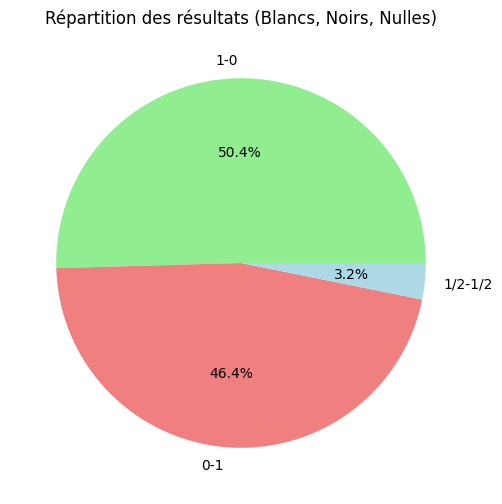


Nombre moyen de coups par partie : 66.65


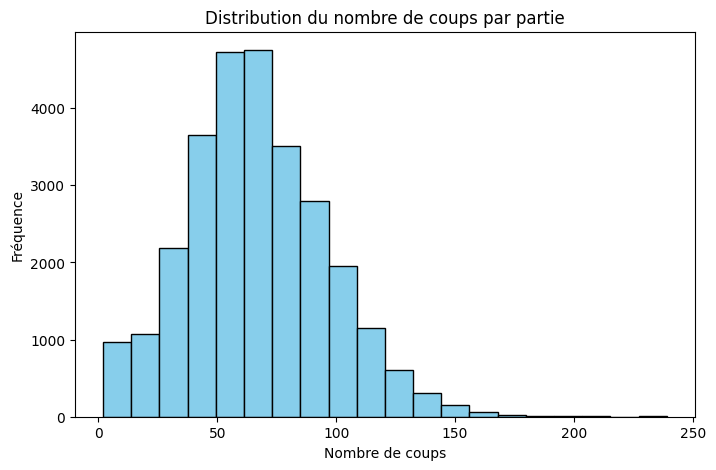

Result                                        Opening  White Win Rate (%)
0                                Van't Kruijs Opening               46.60
1                                      Modern Defense               52.60
2                                   Hungarian Opening               51.67
3                                        Owen Defense               54.76
4                                      Mieses Opening               53.48
5                                     Horwitz Defense               60.16
6       Scandinavian Defense: Mieses-Kotroc Variation               52.97
7                                 Nimzo-Larsen Attack               46.92
8                                   Caro-Kann Defense               43.25
9                    French Defense: Knight Variation               48.74
10                               Queen's Pawn Game #2               56.84
11                               Scandinavian Defense               50.36
12                                    

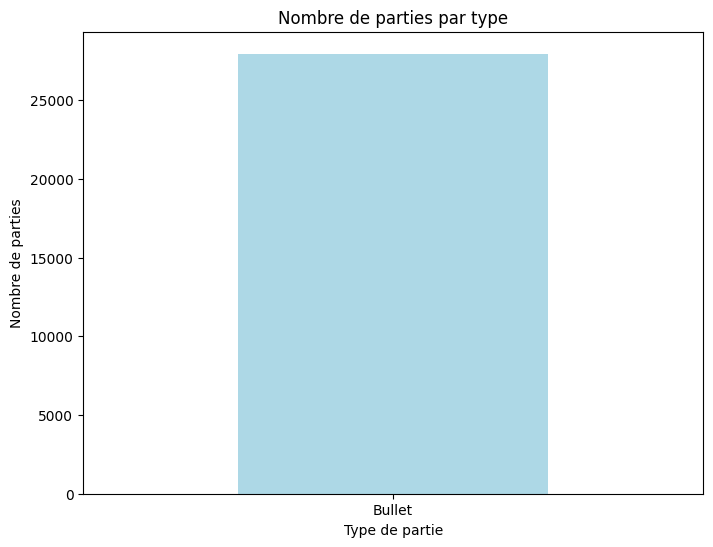

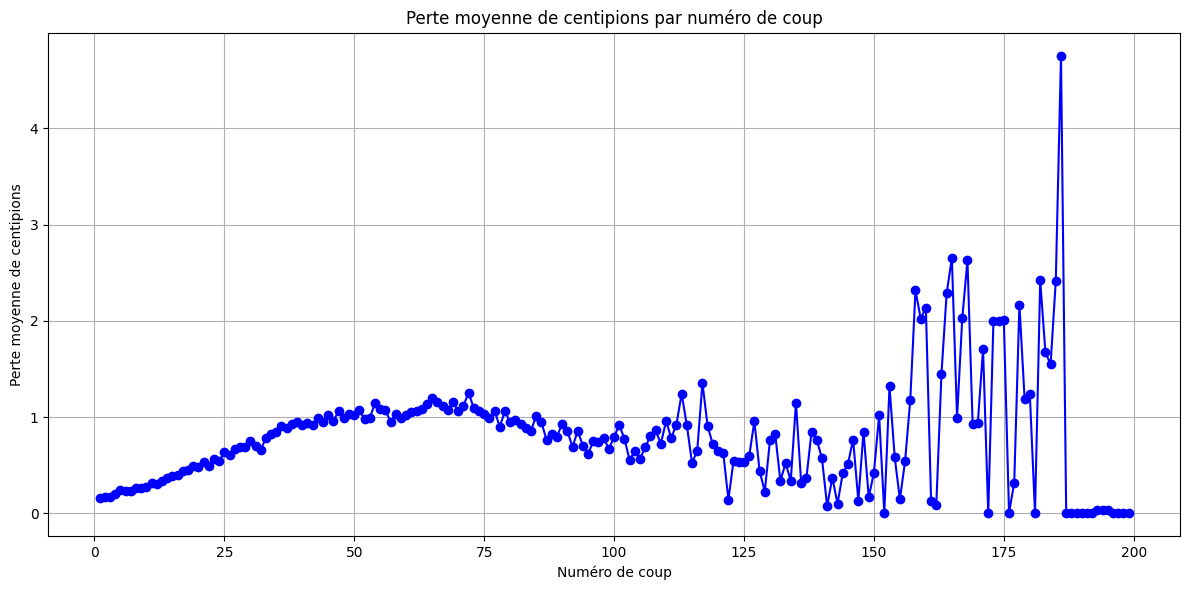


Répartition des résultats :
Result
1-0        26862
0-1        24525
1/2-1/2     2161
Name: count, dtype: int64


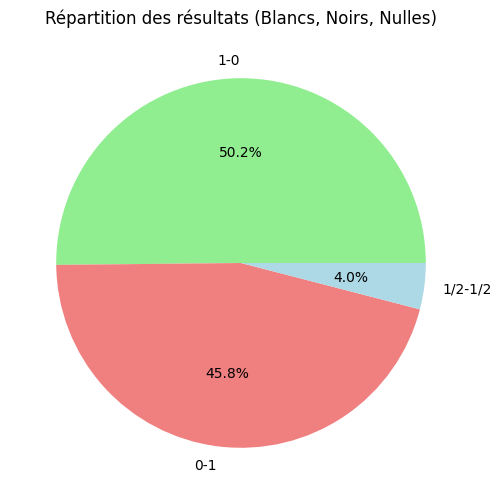


Nombre moyen de coups par partie : 69.49


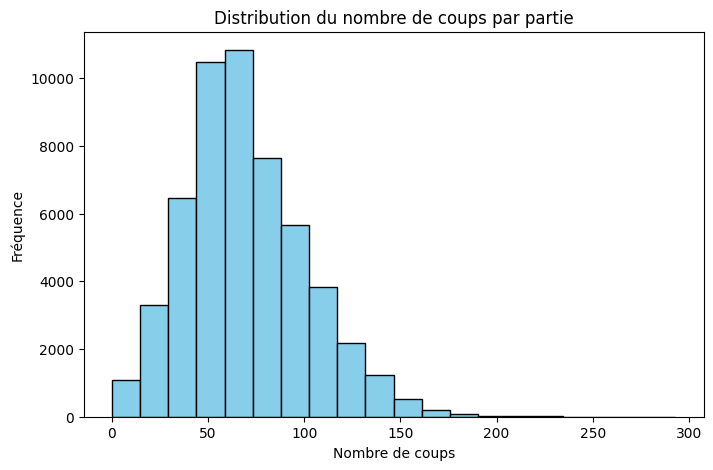

Result                                        Opening  White Win Rate (%)
0                                Van't Kruijs Opening               48.36
1       Scandinavian Defense: Mieses-Kotroc Variation               59.20
2                                     Horwitz Defense               56.72
3                    French Defense: Knight Variation               52.71
4                                      Modern Defense               54.52
5                                    Sicilian Defense               41.46
6                                        Owen Defense               49.93
7                    Sicilian Defense: Bowdler Attack               44.82
8                                 Philidor Defense #3               59.16
9                                   Caro-Kann Defense               49.66
10              Queen's Pawn Game: Chigorin Variation               56.87
11                               Queen's Pawn Game #2               53.31
12                                Phil

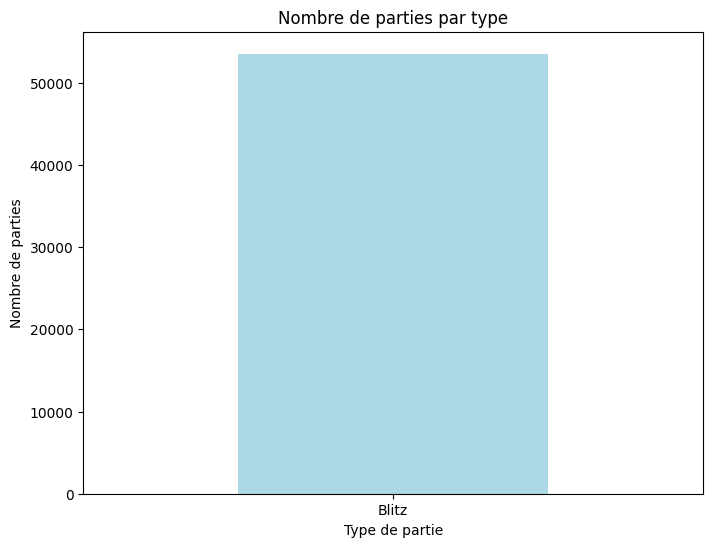

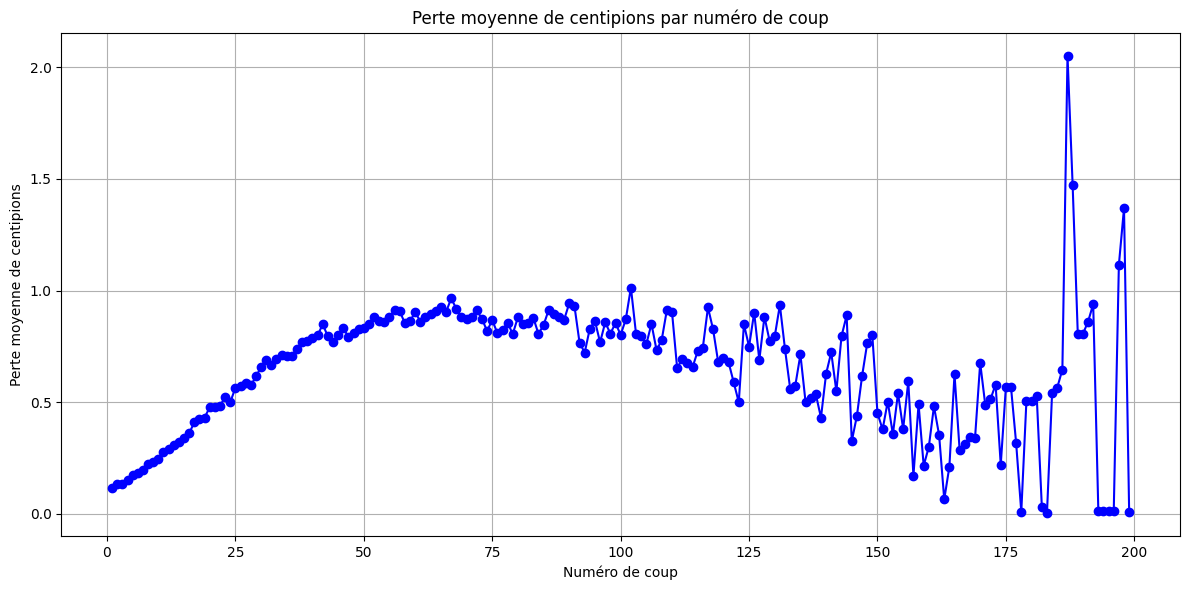


Répartition des résultats :
Result
1-0        5103
0-1        4709
1/2-1/2     503
Name: count, dtype: int64


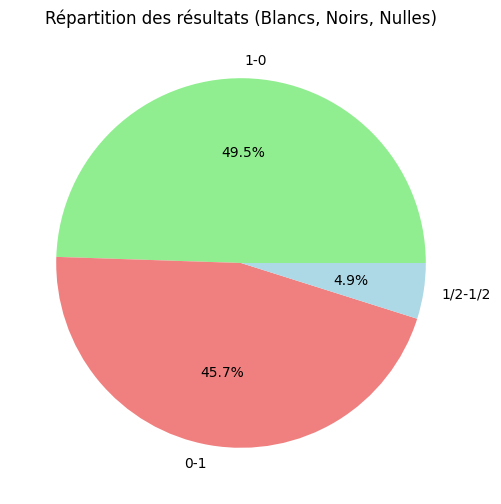


Nombre moyen de coups par partie : 75.24


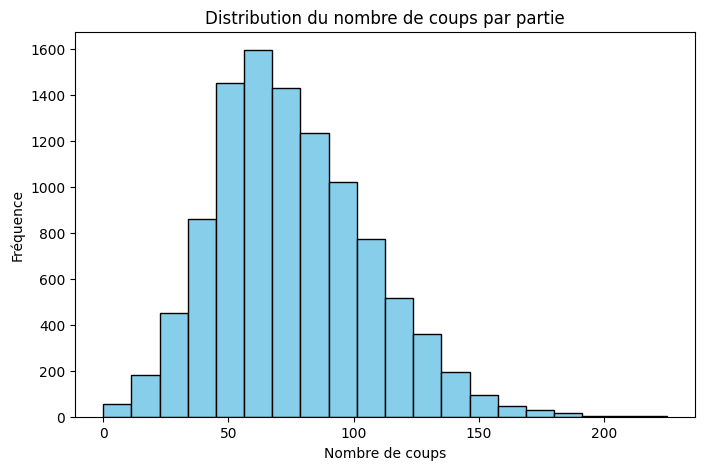

Result                                        Opening  White Win Rate (%)
0                                     Horwitz Defense               50.66
1                                   Caro-Kann Defense               46.85
2                                    Sicilian Defense               48.78
3                                      Modern Defense               56.82
4                      Sicilian Defense: Old Sicilian               50.77
5       Scandinavian Defense: Mieses-Kotroc Variation               55.65
6                    French Defense: Knight Variation               53.45
7                                         Indian Game               50.00
8                    Sicilian Defense: Bowdler Attack               47.12
9                  Sicilian Defense: McDonnell Attack               49.51
10             Queen's Pawn Game: Zukertort Variation               51.04
11                               Van't Kruijs Opening               62.14
12                 French Defense: Exc

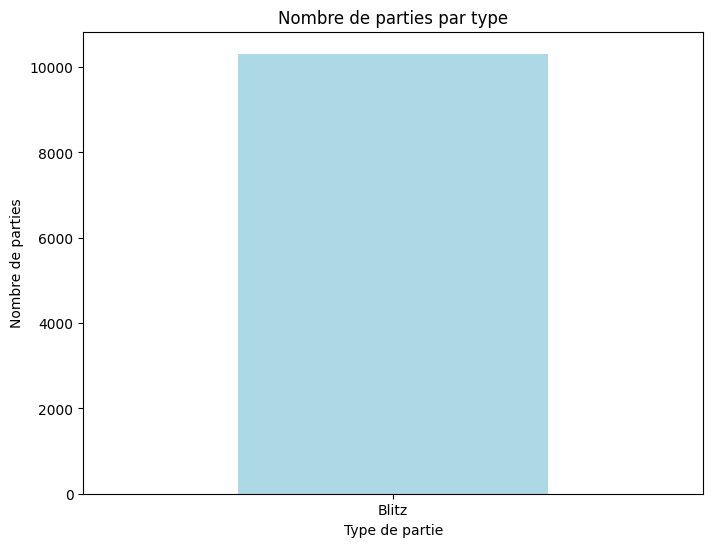

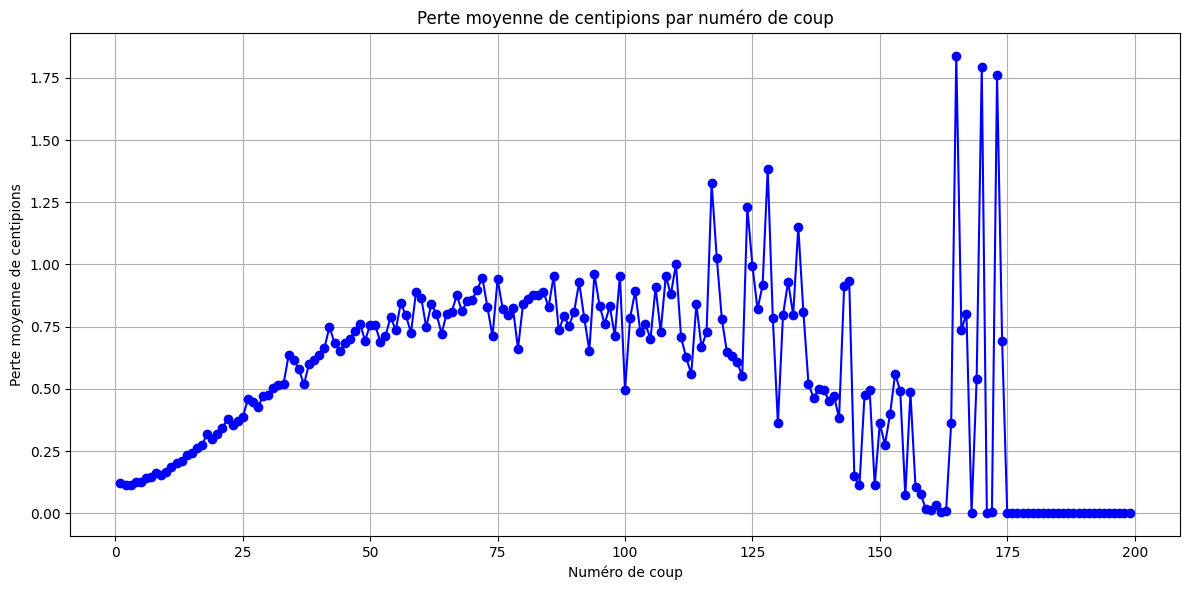


Répartition des résultats :
Result
1-0        3073
0-1        2862
1/2-1/2     252
Name: count, dtype: int64


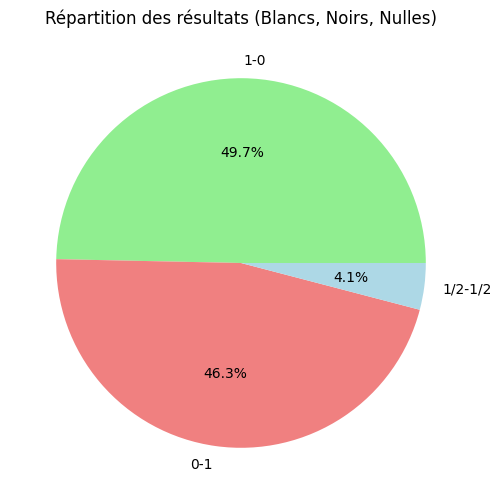


Nombre moyen de coups par partie : 72.32


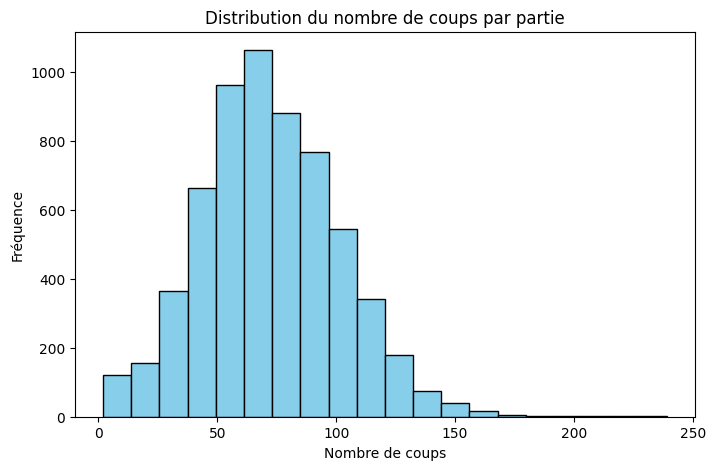

Result                                        Opening  White Win Rate (%)
0                                      Modern Defense               50.41
1                                Van't Kruijs Opening               51.69
2                                   Hungarian Opening               50.93
3                                     Pirc Defense #4               41.61
4                                      Mieses Opening               56.88
5       Scandinavian Defense: Mieses-Kotroc Variation               42.59
6                                Scandinavian Defense               57.14
7                                 Nimzo-Larsen Attack               44.14
8                                        Queen's Pawn               50.00
9                                     Horwitz Defense               58.43
10                                  Caro-Kann Defense               48.31
11                                   Sicilian Defense               41.03
12                                    

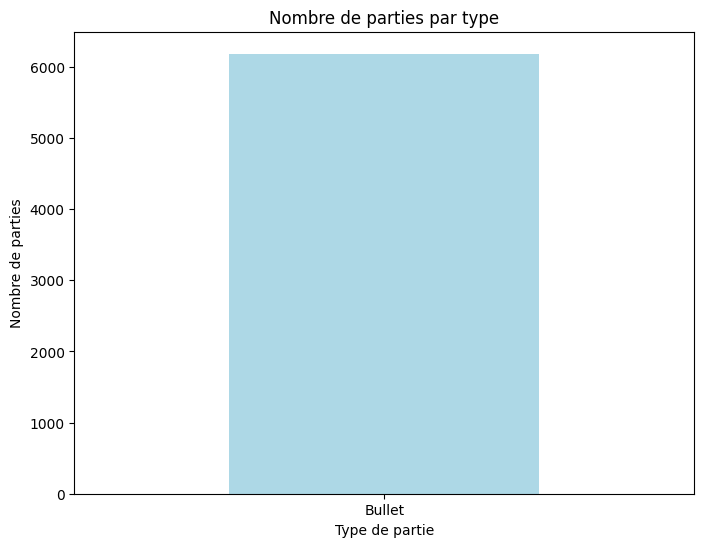

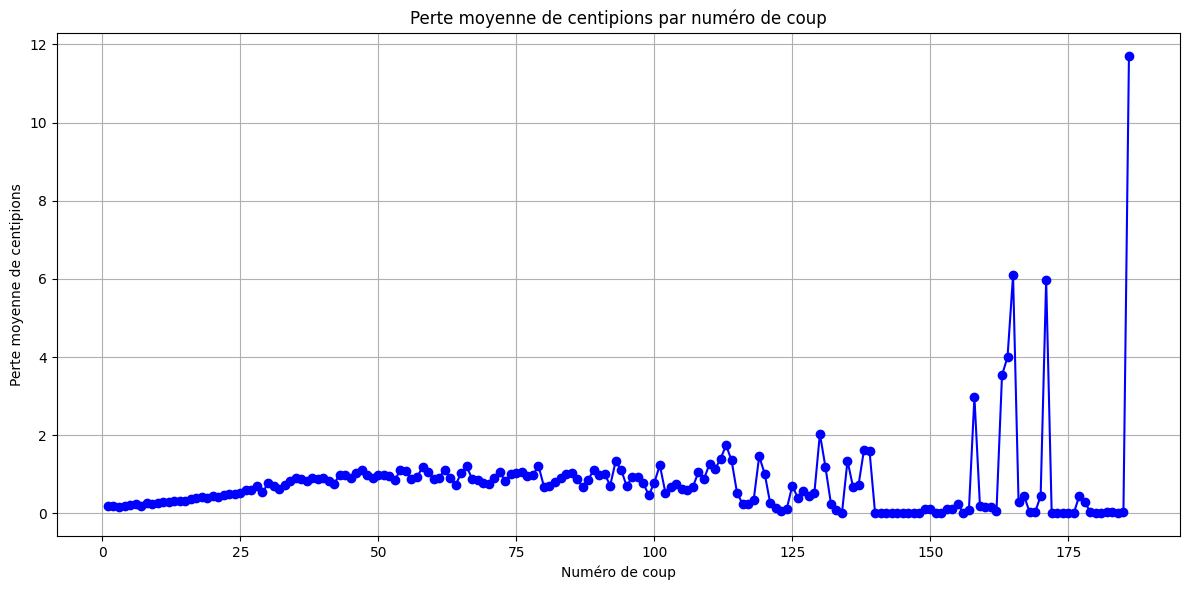

0.1178
0.506


In [27]:
# affichage et filtrations



elo_min =1700
elo_max =2000

#Ajoutez un filtre, celui la garde les parties ou le elo des DEUX JOUEURS est entre elo_min, elo_max

filtered_df_elo = df_games[(df_games["WhiteElo"] >= elo_min) & (df_games["WhiteElo"] <= elo_max) &(df_games["BlackElo"] >= elo_min) & (df_games["BlackElo"] <= elo_max)]

filtered_df_blitz = df_games[df_games["game_type"] == "Blitz"]
filtered_df_bullet = df_games[df_games["game_type"] == "Bullet"]
filtered_evaluated= df_games[df_games["evaluations"].apply(lambda x: isinstance(x, list) and any(eval is not None for eval in x))]
filtered_evaluated_perso = df_games_perso[df_games_perso["evaluations"].apply(lambda x: isinstance(x, list) and any(eval is not None for eval in x))]

filtered_df_elo_blitz=filtered_df_elo[filtered_df_elo["game_type"] == "Blitz"]
filtered_df_elo_bullet=filtered_df_elo[filtered_df_elo["game_type"] == "Bullet"]
#print(df_games["evaluations"])
#print(filtered_evaluated_perso["evaluations"][12])

#statistiques_descriptives(df_games)
statistiques_descriptives(filtered_df_bullet)
statistiques_descriptives(filtered_df_blitz)

statistiques_descriptives(filtered_df_elo_blitz)
statistiques_descriptives(filtered_df_elo_bullet)


#statistiques_descriptives(filtered_evaluated)
#statistiques_descriptives(df_games_perso)
#statistiques_descriptives(filtered_df_blitz)
#statistiques_descriptives(filtered_df_bullet)
#statistiques_descriptives(filtered_evaluated_perso)

print(len(filtered_evaluated)/len(df_games))
print(len(filtered_evaluated_perso)/len(df_games_perso))

Erreur quadratique moyenne : 0.05580656760531813
Coefficient de détermination (R²) : -0.6505404280491456


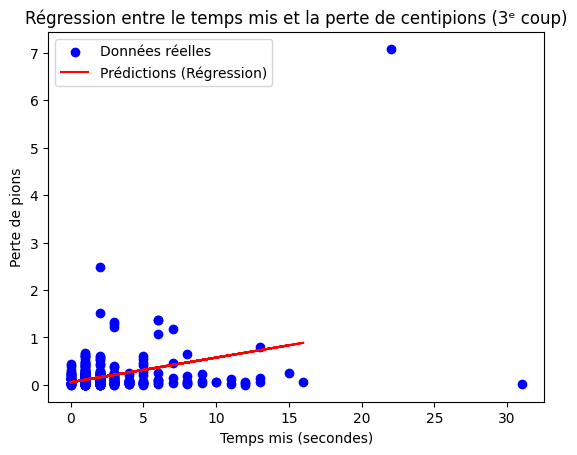

397


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def preprocess_time_by_color(df, i, max_time_per_move=180):

    processed_data = []

    for _, row in df.iterrows():
        clocks = row["clocks"]
        evaluations = row["evaluations"]

        # Vérifier si les données sont valides
        if (
            isinstance(clocks, list)
            and isinstance(evaluations, list)
            and len(clocks) > i
            and len(evaluations) > i
        ):
            try:
                if i % 2 == 0:  # Coup des blancs
                    current_time = clocks[i]
                    previous_time = clocks[i - 2] if i - 2 >= 0 else None
                else:  # Coup des noirs
                    current_time = clocks[i]
                    previous_time = clocks[i - 2] if i - 2 >= 0 else None

                # Convertir les horloges en secondes
                current_time_sec = sum(float(x) * 60 ** idx for idx, x in enumerate(reversed(current_time.split(":"))))
                previous_time_sec = sum(float(x) * 60 ** idx for idx, x in enumerate(reversed(previous_time.split(":")))) if previous_time else None

                # Calcul du temps utilisé
                time_used = previous_time_sec - current_time_sec if previous_time_sec else None

                diff_eval=abs(evaluations[i]-evaluations[i-1])
                # Filtrer les valeurs absurdes
                if time_used is not None and 0 <= time_used <= max_time_per_move:
                    processed_data.append({
                        "time_used": time_used,
                        "centipawn_loss": diff_eval
                    })

            except Exception as e:
                # Ignorer les erreurs dues à des formats incorrects
                continue

    return pd.DataFrame(processed_data)

def perform_regression_on_ith_move(df, i):

    # Prétraiter les données pour le iᵉ coup
    processed_df = preprocess_time_by_color(df, i)

    if processed_df.empty:
        print("Pas de données valides pour le coup", i)
        return

    # Supprimer les lignes contenant des NaN
    processed_df = processed_df.dropna(subset=["time_used", "centipawn_loss"])

    if processed_df.empty:
        print("Pas de données après suppression des NaN pour le coup", i)
        return

    # Diviser les données
    X = processed_df[["time_used"]].values

    y = processed_df["centipawn_loss"].values

    # Vérifier qu'il y a suffisamment de données pour la régression
    if len(X) < 2:
        print("Pas assez de données pour effectuer une régression pour le coup", i)
        return

    # Séparer en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modèle de régression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Prédictions
    y_pred = model.predict(X_test)

    # Affichage des résultats
    print("Erreur quadratique moyenne :", mean_squared_error(y_test, y_pred))
    print("Coefficient de détermination (R²) :", r2_score(y_test, y_pred))

    # Visualisation
    plt.scatter(X, y, color="blue", label="Données réelles")
    plt.plot(X_test, y_pred, color="red", label="Prédictions (Régression)")
    plt.xlabel("Temps mis (secondes)")
    plt.ylabel("Perte de pions")
    plt.title(f"Régression entre le temps mis et la perte de centipions ({i+1}ᵉ coup)")
    plt.legend()
    plt.show()





filtered_evaluated_perso_blitz = filtered_evaluated_perso[filtered_evaluated_perso["game_type"] == "Blitz"]


perform_regression_on_ith_move(filtered_evaluated_perso_blitz, i=2)

#print(filtered_evaluated_df_blitz[["clocks", "evaluations"]].head())

print(len(filtered_evaluated_perso_df_blitz))


#perform_regression_on_ith_move(filtered_evaluated_df_blitz, i=30)


#perform_regression_on_ith_move(filtered_evaluated_perso_df_blitz, i=10)
#processed_df = preprocess_for_ith_move_time_used(filtered_evaluated_perso_df_blitz, i=4)




Nombre de parties Blitz analysées: 53541


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-29-54a75f68a23b>:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_loss_per_elo = stats_df.groupby("ELO_Range")["MeanCentipawnLoss"].mean()


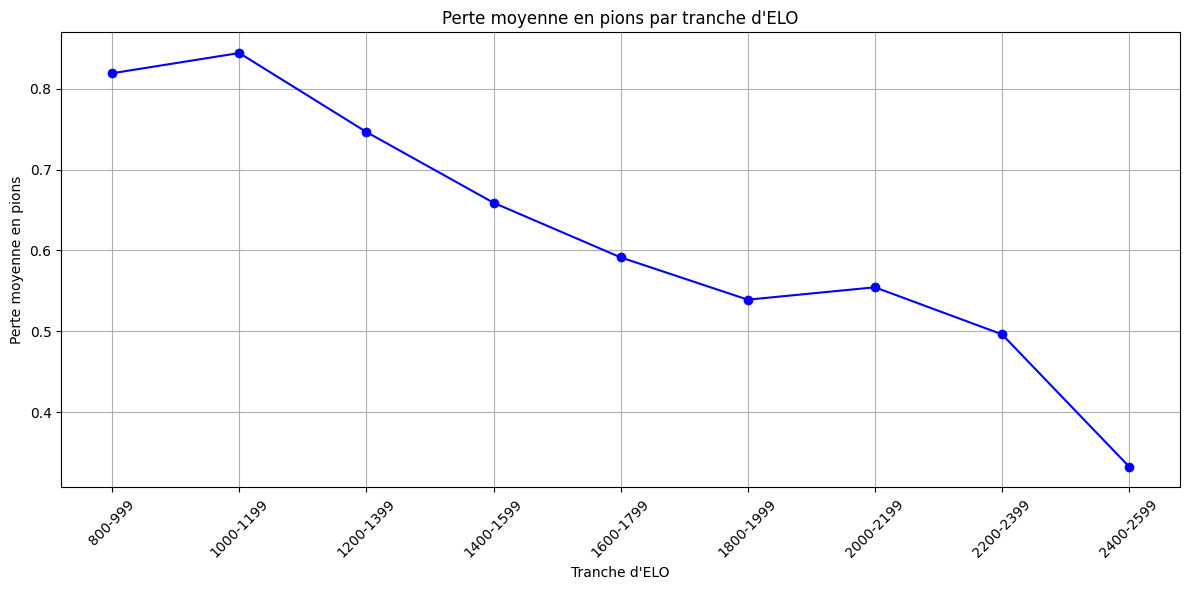

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def filter_analysed_blitz_games(df, elo_range_step=200):


    blitz_df = df[df["game_type"] == "Blitz"]
    blitz_df = blitz_df[blitz_df["centipawn_losses"].apply(lambda x: isinstance(x, list) and len(x) > 0)]
    print(f"Nombre de parties Blitz analysées: {len(blitz_df)}")


    player_stats = []
    for player, group in blitz_df.groupby("White"):
        mean_loss = group["centipawn_losses"].apply(
            lambda losses: np.mean([abs(loss) for loss in losses if loss is not None])
        ).mean()  # Moyenne des pertes sur toutes les parties
        player_elo = group["WhiteElo"].iloc[0]
        player_stats.append({"Player": player, "ELO": player_elo, "MeanCentipawnLoss": mean_loss})


    stats_df = pd.DataFrame(player_stats)

    stats_df["ELO_Range"] = pd.cut(
        stats_df["ELO"],
        bins=np.arange(800, stats_df["ELO"].max() + elo_range_step, elo_range_step),
        labels=[f"{i}-{i+elo_range_step-1}" for i in range(800, stats_df["ELO"].max(), elo_range_step)]
    )

    return stats_df

def plot_elo_vs_centipawn_loss(stats_df):

    mean_loss_per_elo = stats_df.groupby("ELO_Range")["MeanCentipawnLoss"].mean()

    plt.figure(figsize=(12, 6))
    plt.plot(mean_loss_per_elo.index, mean_loss_per_elo.values, marker="o", linestyle="-", color="blue")
    plt.title("Perte moyenne en pions par tranche d'ELO")
    plt.xlabel("Tranche d'ELO")
    plt.ylabel("Perte moyenne en pions")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


filtered_stats_df = filter_analysed_blitz_games(df_games)
plot_elo_vs_centipawn_loss(filtered_stats_df)


In [42]:
def find_most_common_traps(df, threshold=3, max_moves=12, top_n=10):

    traps_data = []


    for _, row in df.iterrows():
        evaluations = row["evaluations"]
        moves = row["Moves"]
        if evaluations and moves:
            for i in range(min(max_moves, len(evaluations))):
                eval_value = evaluations[i]
                if eval_value is not None and abs(eval_value) >= threshold:

                    sequence = " ".join(moves[:i + 1])
                    traps_data.append(sequence)
                    break
    traps_df = pd.DataFrame(traps_data, columns=["Sequence"])
    most_common_traps = traps_df["Sequence"].value_counts().reset_index()
    most_common_traps.columns = ["Sequence","Occurences"]


    return most_common_traps.head(top_n)


print(len(filtered_evaluated))
common_traps = find_most_common_traps(filtered_evaluated, threshold=2, max_moves=6, top_n=10)


print("\nPièges les plus courants (±3 évaluation) :")
print(common_traps)


common_traps.to_csv("most_common_traps.csv", index=False)


11780

Pièges les plus courants (±3 évaluation) :
                        Sequence  Occurences
0  e2e4 e7e5 d2d4 b8c6 d4d5 c6d4           6
1  e2e4 e7e5 g1f3 f7f6 f3e5 f6e5           3
2            e2e4 e7e5 d1h5 g7g6           3
3            e2e4 g8f6 b1c3 f6e4           2
4            e2e4 d7d6 f1c4 b7b6           2
5  e2e4 e7e5 g1f3 b8c6 d2d4 f8c5           2
6  e2e4 d7d5 e4d5 d8d5 b1c3 d5c6           2
7  e2e4 e7e5 f1c4 d7d6 c4f7 e8f7           1
8  b2b4 e7e5 c1b2 f8b4 b2e5 b8c6           1
9            e2e4 f7f5 e4f5 d7d6           1
